# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [86]:
import random
import tensorflow as tf
import numpy as np

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import matplotlib.pyplot as plt
import time
from os import listdir
import os
from tqdm import tqdm


%matplotlib inline



## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [88]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

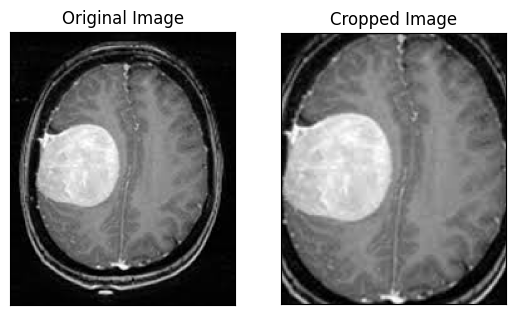

In [89]:
ex_img = cv2.imread('../../yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [90]:
def load_data(dir_list, image_size, grayscale, contrast_enhancement, anisotropic_diffusion, smoothing, bilateral_filtering):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)

            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)

            if grayscale:
                if len(image.shape) == 3:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            # normalize values
            image = image / 255.

            if smoothing:
                    # Create averaging kernel
                    kernel = np.ones((7, 7), np.float32) / (7**2)

                    if grayscale or len(image.shape) == 2:
                        # For grayscale images
                        image = cv2.filter2D(image, -1, kernel)
                    else:
                        # For color images, apply to each channel separately
                        for i in range(3):
                            image[:,:,i] = cv2.filter2D(image[:,:,i], -1, kernel)

            if bilateral_filtering:
                # Convert to uint8 for bilateral filter (it requires uint8)
                image_uint8 = (image * 255).astype(np.uint8)

                # Bilateral filter parameters
                d = 5  # Diameter of each pixel neighborhood
                sigmaColor = 30  # Filter sigma in the color space
                sigmaSpace = 30  # Filter sigma in the coordinate space

                if grayscale or len(image.shape) == 2:
                    # For grayscale images
                    filtered = cv2.bilateralFilter(image_uint8, d, sigmaColor, sigmaSpace)
                    image = filtered.astype(np.float32) / 255.0
                else:
                    # For color images, apply to each channel separately
                    filtered = np.zeros_like(image_uint8)
                    for i in range(3):
                        filtered[:,:,i] = cv2.bilateralFilter(image_uint8[:,:,i], d, sigmaColor, sigmaSpace)
                    image = filtered.astype(np.float32) / 255.0

            if anisotropic_diffusion:
                aniso_niter = 10
                aniso_kappa = 50
                aniso_gamma = 0.1
                aniso_option = 1

                if grayscale or len(image.shape) == 2:
                    # For grayscale images
                    image = anisotropic_diffusion(
                        image,
                        niter=aniso_niter,
                        kappa=aniso_kappa,
                        gamma=aniso_gamma,
                        option=aniso_option
                    )
                else:
                    # For color images, apply to each channel separately
                    for i in range(3):
                        image[:,:,i] = anisotropic_diffusion(
                            image[:,:,i],
                            niter=aniso_niter,
                            kappa=aniso_kappa,
                            gamma=aniso_gamma,
                            option=aniso_option
                        )

            if contrast_enhancement:
                clahe = cv2.createCLAHE(clipLimit=3.0,
                                        tileGridSize=(8, 8))

                if grayscale or len(image.shape) == 2:
                    image_uint8 = (image * 255).astype(np.uint8)
                    image = clahe.apply(image_uint8).astype(np.float32) / 255.0
                else:
                    image_uint8 = (image * 255).astype(np.uint8)
                    for i in range(3):
                        image[:,:,i] = clahe.apply(image_uint8[:,:,i]).astype(np.float32) / 255.0

            # Reshape grayscale images to have a channel dimension
            if grayscale or len(image.shape) == 2:
                image = np.expand_dims(image, axis=-1)

            # convert image to numpy array and append it to X
            X.append(image)

            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [91]:
def add_implant_artifact(image, min_radius=50, max_radius=100):
    """
    Add a single simulated brain implant artifact to an MRI scan.

    Args:
        image: Input MRI image
        min_radius: Minimum radius of artifact (default: 15 pixels)
        max_radius: Maximum radius of artifact (default: 30 pixels)

    Returns:
        Image with simulated implant artifact
    """
    img_with_artifact = image.copy()
    height, width = image.shape[:2]

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    _, brain_mask = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        brain_coords = np.column_stack(np.where(brain_mask > 0))
        if len(brain_coords) == 0:
            return img_with_artifact  # No brain detected, return original image

    # Single larger artifact
    radius = random.randint(min_radius, max_radius)

    if contours:
        # Find the largest contour (brain)
        brain_contour = max(contours, key=cv2.contourArea)
        # Get the moments of the contour
        M = cv2.moments(brain_contour)

        # Calculate the center of the brain
        if M["m00"] != 0:
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])
        else:
            center_x, center_y = width // 2, height // 2

        # Calculate distance from center to place artifact randomly but within brain
        max_distance = min(width, height) // 4
        distance = random.randint(0, max_distance)
        angle = random.uniform(0, 2 * np.pi)

        x = int(center_x + distance * np.cos(angle))
        y = int(center_y + distance * np.sin(angle))

        # Ensure coordinates are within image boundaries
        x = max(radius, min(width - radius, x))
        y = max(radius, min(height - radius, y))
    else:
        # Fallback: place artifact randomly
        x = random.randint(radius, width - radius)
        y = random.randint(radius, height - radius)

    # Create the artifact (black circle)
    cv2.circle(img_with_artifact, (x, y), radius, (0, 0, 0), -1)

    # Add some blur to make it look more realistic
    img_with_artifact = cv2.GaussianBlur(img_with_artifact, (5, 5), 0)

    return img_with_artifact

In [92]:
def augment_data_implant(input_dir, output_dir, percentage=0.5):
    """
    Process the dataset by adding a single implant artifact to a percentage of images

    Args:
        input_dir: Input directory containing MRI images
        output_dir: Output directory for augmented images
        percentage: Percentage of images to augment (default: 0.5)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get list of all images in input directory
    images = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Determine which images to augment
    num_to_augment = int(len(images) * percentage)
    images_to_augment = random.sample(images, num_to_augment)

    print(f"Processing {len(images)} images, augmenting {num_to_augment}")

    for img_name in tqdm(images):
        # Read the image
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Failed to read image: {img_path}")
            continue

        # Convert to RGB (OpenCV reads as BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # If this image is selected for augmentation, add artifact
        if img_name in images_to_augment:
            # Add a single larger artifact
            augmented = add_implant_artifact(image)

            # Save the augmented image
            output_path = os.path.join(output_dir, img_name)
            augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, augmented_bgr)

            # Visualize the original and augmented images
            fig, axes = plt.subplots(1, 2, figsize=(5, 5))
            axes = axes.flatten()
            axes[0].imshow(image, cmap='gray')
            axes[0].axis('off')
            axes[1].imshow(augmented, cmap='gray')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()
        else:
            # Copy original image to output directory
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, image)

In [93]:
original_augmented_path = '../../augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
original_augmented_yes = original_augmented_path + 'yes'
original_augmented_no = original_augmented_path + 'no'

implant_augmented_path = 'implant_augmented_data/'

implant_augmented_yes = implant_augmented_path + 'yes'
implant_augmented_no = implant_augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

# augment_data_implant(original_augmented_yes, implant_augmented_yes, percentage=0.5)
# augment_data_implant(original_augmented_no, implant_augmented_no, percentage=0.5)

X, y = load_data(
    [original_augmented_yes, original_augmented_no],
    (IMG_WIDTH, IMG_HEIGHT),
    grayscale=False,
    contrast_enhancement=False,
    anisotropic_diffusion=False,
    smoothing=False,
    bilateral_filtering=False
)
NAME = "original"
filepath=NAME

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [94]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0], cmap='gray')
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

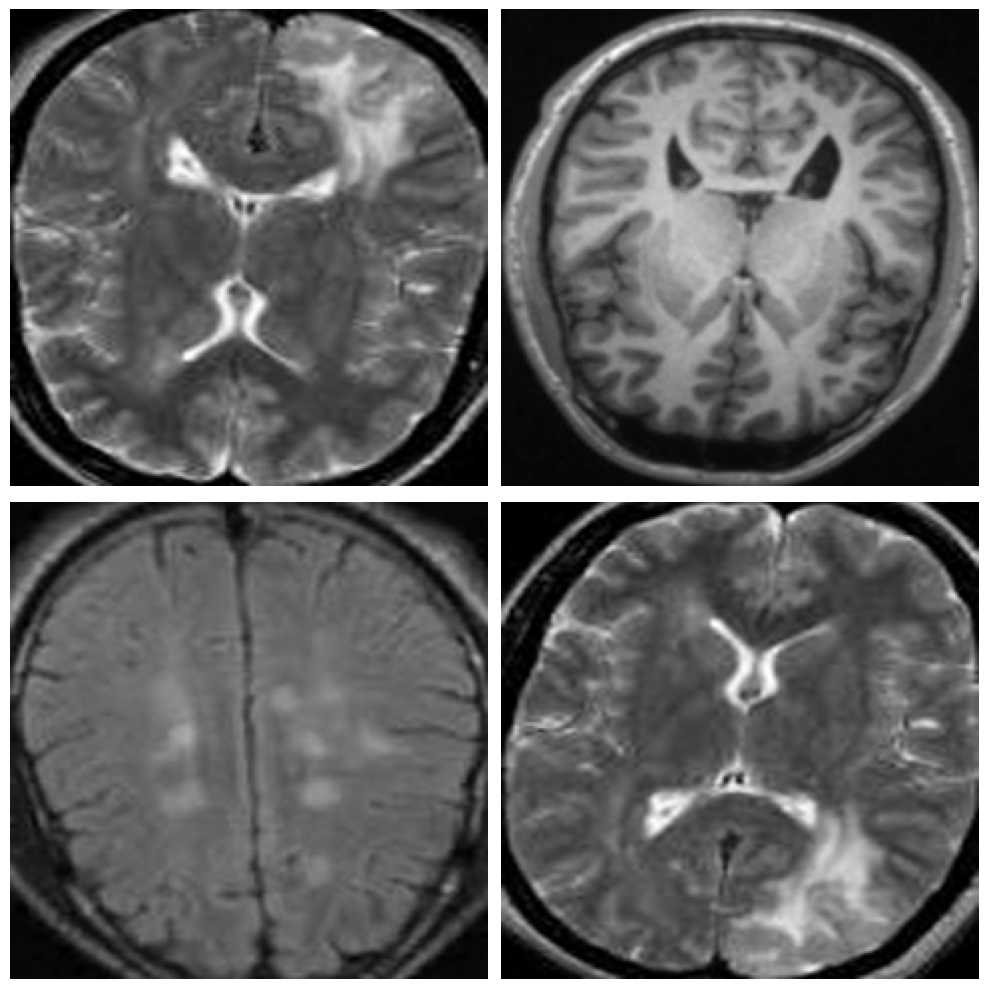

In [95]:
# plot_sample_images(X, y)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i in range(4):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].axis('off')  # Remove axes

plt.tight_layout()

plt.savefig(f"images/{NAME}.png", dpi=300)

plt.show()

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [96]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [97]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [98]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [99]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [100]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [101]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [102]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [103]:
model = build_model(IMG_SHAPE)

In [104]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [105]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [107]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
# filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [108]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint], shuffle=True)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 28s 537ms/step - accuracy: 0.5842 - loss: 1.0372 - val_accuracy: 0.6226 - val_loss: 0.6549
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 23s 494ms/step - accuracy: 0.7451 - loss: 0.5238 - val_accuracy: 0.5452 - val_loss: 0.6579
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 478ms/step - accuracy: 0.7881 - loss: 0.4480 - val_accuracy: 0.5645 - val_loss: 0.6535
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.8421 - loss: 0.3863 - val_accuracy: 0.7097 - val_loss: 0.5417
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 474ms/step - accuracy: 0.8530 - loss: 0.3530 - val_accuracy: 0.7226 - val_loss: 0.5218
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.8694 - loss: 0.3300 - val_accuracy: 0.7226 - val_loss: 0.5034
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 471ms/step - accuracy: 0.8783 - loss: 0.3018 - val_accuracy: 0.6516 - val_loss: 0.6340
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 485ms/step - accuracy: 0.8953 - loss: 0.2669 - val_accu

In [109]:
history = model.history.history

In [110]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [111]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    plt.savefig(f"images/{NAME}-metrics.png", dpi=300)

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

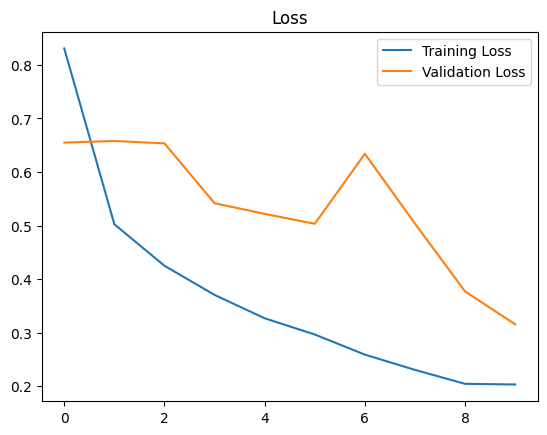

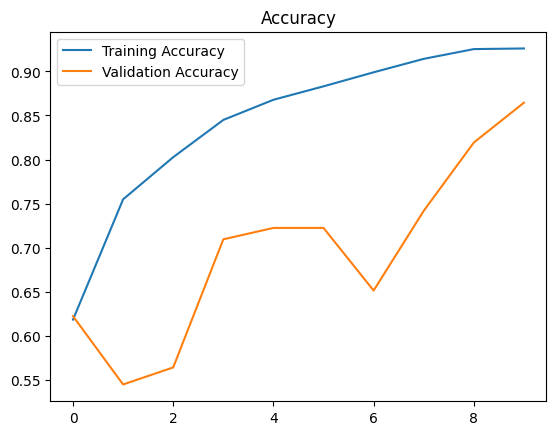

<Figure size 640x480 with 0 Axes>

In [112]:
plot_metrics(history)

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [113]:
# best_model = load_model(filepath='models/cnn-parameters-improvement-04-0.81.keras')
best_model = model

In [114]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [115]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

y_test_prob = best_model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)

print (f"Test Accuracy = {acc}")
print(f"Test F1 score: {f1score}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8509 - loss: 0.3390
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Test Accuracy = 0.8645161390304565
Test F1 score: 0.8771929824561403


In [116]:
val_loss, val_acc = model.evaluate(x=X_val, y=y_val)

y_val_prob = model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)

print (f"Validation Accuracy = {val_acc}")
print(f"Validation F1 score: {f1score_val}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8690 - loss: 0.3093
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Validation Accuracy = 0.8645161390304565
Validation F1 score: 0.8833333333333333


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [117]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [118]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [119]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 51.21107266435986%, number of pos examples: 740
Percentage of negative examples: 48.78892733564014%, number of neg examples: 705
Validation Data:
Number of examples: 310
Percentage of positive examples: 57.41935483870968%, number of pos examples: 178
Percentage of negative examples: 42.58064516129032%, number of neg examples: 132
Testing Data:
Number of examples: 310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143
